In [91]:
import pandas as pd
import datetime as dt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import pylab 
import scipy.stats as stats

In [175]:
def shift_y(series):
    if series['Month'] == 1:
        return series['Year']-1
    else:
        return series['Year']
def shift_m(series):
    if series['Month'] == 1:
        return 12
    else:
        return series['Month']-1
def toDateMY(series):
    y = series['YearShift']
    m = series['MonthShift']
    days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
    if y%4 == 0:
        d = days_per_month_ly[int(m)-1]
    else:
        d = days_per_month[int(m)-1]
    return dt.datetime.strptime(""+str(int(series['YearShift']))+"-"+str(int(series['MonthShift']))+"-"+str(d), '%Y-%m-%d')
def toDate2(series):
    return dt.datetime.strptime(series[:-9], '%Y-%m-%d')

In [3]:
#Download utilities and shift year/month by one
df0 = pd.read_csv('~/Downloads/repairs_utilities_all_sqft.csv')
df1 = pd.read_csv('~/Downloads/utilities_sqft.csv')
df0['YearShift'] = df0[['Year', 'Month']].apply(shift_y, axis=1)
df0['MonthShift'] = df0[['Year', 'Month']].apply(shift_m, axis=1)

df1['YearShift'] = df1[['Year', 'Month']].apply(shift_y, axis=1)
df1['MonthShift'] = df1[['Year', 'Month']].apply(shift_m, axis=1)


In [16]:
def preprocess(serviceType, bySqFt):
    if bySqFt:
        consumption_col = 'ConsumptionPerSQFT'
    else:
        consumption_col = 'Consumption'
    #Filter by service type
    df = df1[df1['ServiceType']==serviceType]
    print("Number of Records with this service type")
    print(df.shape)
    #Filter out addresses with emergency repairs projects
    project_addresses = df0['address'].unique()
    df = df[~df['address'].isin(project_addresses)]
    print("Number of Records after dropping project addresses")
    print(df.shape)
    #group by month, year, address, type
    sr = df[['YearShift', 'MonthShift', 'ServiceType', 'address', consumption_col]].copy()
    sr = sr.groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'address']).sum().reset_index()
    #Get consumption normalized by days per month
    days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
    sr['Consumption_norm'] = sr[consumption_col]
    for y in range(2001, 2020):
        for m in range(1,13):
            record_u = sr.loc[(sr['YearShift']==y)&(sr['MonthShift']==m), :]
            #Temp fix
            if y == 2018 and m == 9:
                sr.loc[record_u.index, 'Consumption_norm'] = sr.loc[record_u.index, consumption_col]/days_per_month[m-1]/3
            if y%4 == 0:
                sr.loc[record_u.index, 'Consumption_norm'] = sr.loc[record_u.index, consumption_col]/days_per_month_ly[m-1]
            else:
                sr.loc[record_u.index, 'Consumption_norm'] = sr.loc[record_u.index, consumption_col]/days_per_month[m-1]
    #Include only addresses which have consistent month data for the type (defined as >=80 records)
    ct = sr.groupby(by=['address']).count()
    addresses = ct[ct[consumption_col]>=80]
    print("Number of records after consolidating repeat bills in a month")
    print(sr.shape)
    sr_sub = sr[sr['address'].isin(addresses.index)].copy() 
    print("Number of records after dropping addresses with inconsistent billing records")
    print(sr_sub.shape)
    #Drop addresses which have years that had no consumption
    gp = sr_sub.groupby(by=['address', 'YearShift']).sum()
    drop_addrs = []
    for a in gp.index.levels[0]:
        drop=False
        for y in range(2011, 2019):
            try:
                if gp.loc[a,y]['Consumption_norm'] == 0:
                    drop=True
            except TypeError:
                drop=True
        if drop:
            drop_addrs.append(a)
    drop_idx = sr_sub[sr_sub['address'].isin(drop_addrs)].index
    sr_sub.drop(drop_idx, inplace=True) #Drop addresses with 0 consumption over a year
    print("Number of records after dropping addresses with 0 consumption in a year")
    print(sr_sub.shape)
    #Get the minimum and maximum values
    #min_c = sr_sub[['Consumption_norm', 'address']].groupby(by='address').min()
    max_c = sr_sub[['Consumption_norm', 'address']].groupby(by='address').max()   
    #Normalize address on 0-1 scale
    def normalize(series):
        a = series['address']
        mi = 0
        ma = max_c.loc[a]['Consumption_norm']
        return (series['Consumption_norm']-mi)/(ma-mi)
    sr_sub['Consumption_01'] = sr_sub.apply(normalize, axis=1)
    return sr_sub

In [13]:
#Electricity, not normalized by square footage
df_e1 = preprocess('RELC', False)

Number of Records with this service type
(1386880, 11)
Number of Records after dropping project addresses
(1382438, 11)
Number of records after consolidating repeat bills in a month
(1273770, 6)
Number of records after dropping addresses with inconsistent billing records
(994312, 6)
Number of records after dropping addresses with 0 consumption in a year
(988356, 6)


In [17]:
#Electricity, normalized by square footage
df_e2 = preprocess('RELC', True)

Number of Records with this service type
(1386880, 11)
Number of Records after dropping project addresses
(1382438, 11)
Number of records after consolidating repeat bills in a month
(1273770, 6)
Number of records after dropping addresses with inconsistent billing records
(994312, 6)
Number of records after dropping addresses with 0 consumption in a year
(988356, 6)


In [18]:
#Gas, not normalized by square footage
df_g1 = preprocess('RGAS', False)

Number of Records with this service type
(722576, 11)
Number of Records after dropping project addresses
(719917, 11)
Number of records after consolidating repeat bills in a month
(692201, 6)
Number of records after dropping addresses with inconsistent billing records
(450979, 6)
Number of records after dropping addresses with 0 consumption in a year
(408574, 6)


In [23]:
#Gas, not normalized by square footage
df_g2 = preprocess('RGAS', True)

Number of Records with this service type
(722576, 11)
Number of Records after dropping project addresses
(719917, 11)
Number of records after consolidating repeat bills in a month
(692201, 6)
Number of records after dropping addresses with inconsistent billing records
(450979, 6)
Number of records after dropping addresses with 0 consumption in a year
(408574, 6)


# Investigate specific month
Electricity with no square footage

(0.3999561667442322, 0.0)

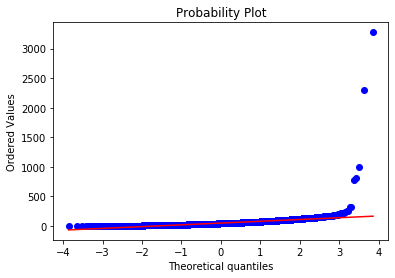

In [47]:

#Consumption per month is not normal
ONE_MONTH = df_e1[(df_e1['MonthShift']==2) & (df_e1['YearShift'] == 2015)]
stats.probplot(ONE_MONTH['Consumption_norm'], dist="norm", plot=pylab)
stats.shapiro(ONE_MONTH['Consumption_norm'])

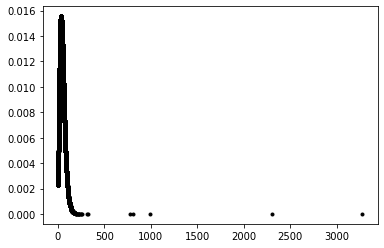

In [48]:
#Kernel Density Estimation
data = np.array(ONE_MONTH['Consumption_norm'])
r = np.array([xmin+0.0001*i for i in range(int((xmax-xmin)/0.0001))])
xmin = data.min()
xmax = data.max()
kernel = stats.gaussian_kde(data)
Z = kernel(data.ravel())
x =plt.plot(data, Z, '.k')


Electricity with square footage

(0.21577715873718262, 0.0)

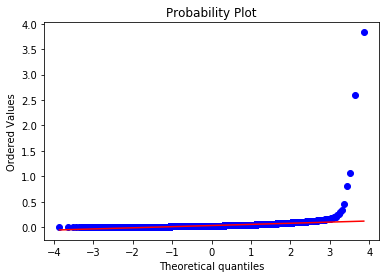

In [49]:
#Consumption per month is not normal
ONE_MONTH = df_e2[(df_e2['MonthShift']==2) & (df_e2['YearShift'] == 2015)]
stats.probplot(ONE_MONTH['Consumption_norm'], dist="norm", plot=pylab)
stats.shapiro(ONE_MONTH['Consumption_norm'])

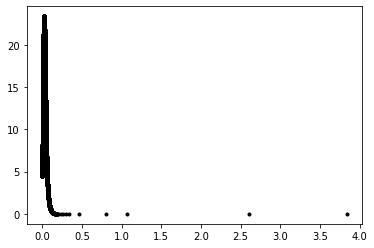

In [50]:
#Kernel Density Estimation
data = np.array(ONE_MONTH['Consumption_norm'])
r = np.array([xmin+0.0001*i for i in range(int((xmax-xmin)/0.0001))])
xmin = data.min()
xmax = data.max()
kernel = stats.gaussian_kde(data)
Z = kernel(data.ravel())
x =plt.plot(data, Z, '.k')


Gas with no square footage

(0.9498034119606018, 1.8300030284498728e-38)

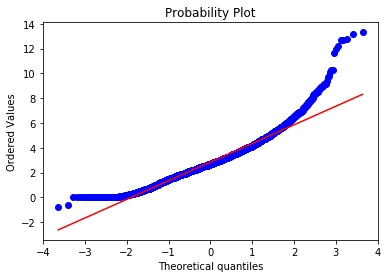

In [51]:
#Consumption per month is not normal
ONE_MONTH = df_g1[(df_g1['MonthShift']==2) & (df_g1['YearShift'] == 2015)]
stats.probplot(ONE_MONTH['Consumption_norm'], dist="norm", plot=pylab)
stats.shapiro(ONE_MONTH['Consumption_norm'])

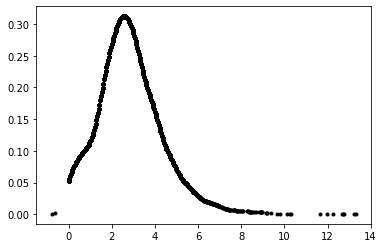

In [52]:
#Kernel Density Estimation
data = np.array(ONE_MONTH['Consumption_norm'])
r = np.array([xmin+0.0001*i for i in range(int((xmax-xmin)/0.0001))])
xmin = data.min()
xmax = data.max()
kernel = stats.gaussian_kde(data)
Z = kernel(data.ravel())
x =plt.plot(data, Z, '.k')


Gas with square footage

(0.9437785744667053, 3.6699866650820527e-40)

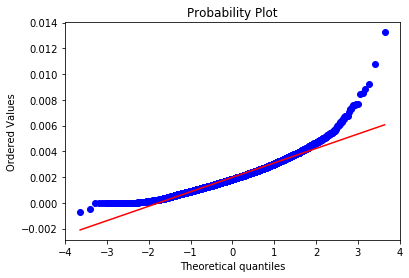

In [53]:
#Consumption per month is not normal
ONE_MONTH = df_g2[(df_g2['MonthShift']==2) & (df_g2['YearShift'] == 2015)]
stats.probplot(ONE_MONTH['Consumption_norm'], dist="norm", plot=pylab)
stats.shapiro(ONE_MONTH['Consumption_norm'])

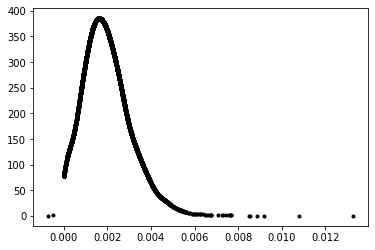

In [54]:
#Kernel Density Estimation
data = np.array(ONE_MONTH['Consumption_norm'])
r = np.array([xmin+0.0001*i for i in range(int((xmax-xmin)/0.0001))])
xmin = data.min()
xmax = data.max()
kernel = stats.gaussian_kde(data)
Z = kernel(data.ravel())
x =plt.plot(data, Z, '.k')


### Plot mean consumption over time

In [133]:
def preprocess2(df1, serviceType, bySqFt):
    print(serviceType,", Square Footage =", bySqFt)
    if bySqFt:
        consumption_col = 'ConsumptionPerSQFT'
    else:
        consumption_col = 'Consumption'
    #Filter by service type
    df = df1[df1['ServiceType']==serviceType]
    print("Number of Records with this service type")
    print(df.shape)
    #group by month, year, address, type
    sr = df[['YearShift', 'MonthShift', 'ServiceType', 'address', consumption_col]].copy()
    sr = sr.groupby(by=['YearShift', 'MonthShift', 'ServiceType', 'address']).sum().reset_index()
    #Get consumption normalized by days per month
    days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    days_per_month_ly =[31,29,31,30,31,30,31,31,30,31,30,31]
    sr['Consumption_norm'] = sr[consumption_col]
    for y in range(2001, 2020):
        for m in range(1,13):
            record_u = sr.loc[(sr['YearShift']==y)&(sr['MonthShift']==m), :]
            if y%4 == 0:
                sr.loc[record_u.index, 'Consumption_norm'] = sr.loc[record_u.index, consumption_col]/days_per_month_ly[m-1]
            else:
                sr.loc[record_u.index, 'Consumption_norm'] = sr.loc[record_u.index, consumption_col]/days_per_month[m-1]
    print("Number of records after consolidating repeat bills in a month")
    print(sr.shape)
    sr_sub = sr.copy()
    #Drop addresses which have years that had no consumption over a year
    gp = sr_sub.groupby(by=['address', 'YearShift']).sum()
    drop_idx = []
    for a in gp.index.levels[0]:
        for y in range(2011, 2019):
            try:
                if gp.loc[a,y]['Consumption_norm'] == 0:
                    idx = sr_sub[(sr_sub['address'] == a) & (sr_sub['YearShift']==y)].index
                    drop_idx = drop_idx+list(idx)
            except TypeError:
                continue
#     print(len(drop_idx))
#     print(drop_idx)
    sr_sub.drop(drop_idx, inplace=True)

    print("Number of records after dropping records where the year had no consumption")
    print(sr_sub.shape)
    print("Number of records dropped")
    print(len(drop_idx))
    return sr_sub

In [105]:
df_e = preprocess2(df1, 'RELC', True)
print('-'*30)
df_g = preprocess2(df1, 'RGAS', True)

RELC , Square Footage = True
Number of Records with this service type
(1386880, 11)
Number of records after consolidating repeat bills in a month
(1278094, 6)
Number of records after dropping records where the year had no consumption
(1276934, 6)
Number of records dropped
1160
------------------------------
RGAS , Square Footage = True
Number of Records with this service type
(722576, 11)
Number of records after consolidating repeat bills in a month
(694796, 6)
Number of records after dropping records where the year had no consumption
(657783, 6)
Number of records dropped
37013


In [160]:
#temporarily drop month with issue
df_e2= df_e.drop(df_e[(df_e['YearShift']==2018)&(df_e['MonthShift']==9)].index)
df_g2= df_g.drop(df_g[(df_g['YearShift']==2018)&(df_g['MonthShift']==9)].index)
e_mean = df_e2[['Consumption_norm', 'YearShift', 'MonthShift']].groupby(by=['YearShift', 'MonthShift']).mean().reset_index(level=[0,1])
e_statsum = df_e2[['Consumption_norm', 'YearShift', 'MonthShift']].groupby(by=['YearShift', 'MonthShift']).describe()
g_mean = df_g2[['Consumption_norm', 'YearShift', 'MonthShift']].groupby(by=['YearShift', 'MonthShift']).mean().reset_index(level=[0,1])
g_statsum = df_g2[['Consumption_norm', 'YearShift', 'MonthShift']].groupby(by=['YearShift', 'MonthShift']).describe()

In [161]:
#Read in weather data
w0 = pd.read_csv("~/Dropbox/CDS-2019-AlbanyHub/ToDatabase/LCD_month.csv")
w = w0.loc[w0['YEAR']>=2012, :].copy()


In [176]:
def create_plot(e, w):
#     #Plottable date
#     e = energy.copy()
#     w = weather.copy()
    w['DATE2'] = w['DATE'].apply(toDate2)
    e['DATE'] = e.apply(toDateMY, axis=1)
    ax1 = plt.subplot(211)
    plt.plot(e['DATE'], e['Consumption_norm'])
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(w['DATE2'], w['MonthlyMeanTemperature'])
    plt.setp(ax2.get_xticklabels(),fontsize=12)
    plt.show()

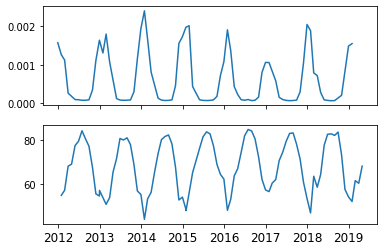

In [177]:
create_plot(g_mean, w)

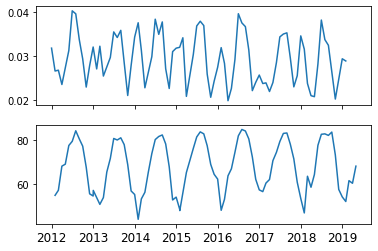

In [178]:
create_plot(e_mean, w)

## Investigate for HOME projects

In [153]:
df_home= pd.read_csv('/home/mirabel/Dropbox (GaTech)/CDS-2019-AlbanyHub/subsets of utilities/HOME_utilities_sqft.csv')
df_home['YearShift'] = df_home[['Year', 'Month']].apply(shift_y, axis=1)
df_home['MonthShift'] = df_home[['Year', 'Month']].apply(shift_m, axis=1)


In [134]:
df_he = preprocess2(df_home, 'RELC', True)
df_hg = preprocess2(df_home, 'RGAS', True)

RELC , Square Footage = True
Number of Records with this service type
(19483, 11)
Number of records after consolidating repeat bills in a month
(7487, 6)
Number of records after dropping records where the year had no consumption
(7440, 6)
Number of records dropped
47
RGAS , Square Footage = True
Number of Records with this service type
(2841, 11)
Number of records after consolidating repeat bills in a month
(2682, 6)
Number of records after dropping records where the year had no consumption
(2407, 6)
Number of records dropped
275


In [179]:
#Temporarily drop month/year with issue
df_he2= df_he.drop(df_he[(df_he['YearShift']==2018)&(df_he['MonthShift']==9)].index)
df_hg2= df_hg.drop(df_hg[(df_hg['YearShift']==2018)&(df_hg['MonthShift']==9)].index)
he_mean = df_he2[['Consumption_norm', 'YearShift', 'MonthShift']].groupby(by=['YearShift', 'MonthShift']).mean().reset_index(level=[0,1])
he_statsum = df_he2[['Consumption_norm', 'YearShift', 'MonthShift']].groupby(by=['YearShift', 'MonthShift']).describe()
hg_mean = df_hg2[['Consumption_norm', 'YearShift', 'MonthShift']].groupby(by=['YearShift', 'MonthShift']).mean().reset_index(level=[0,1])
hg_statsum = df_hg2[['Consumption_norm', 'YearShift', 'MonthShift']].groupby(by=['YearShift', 'MonthShift']).describe()

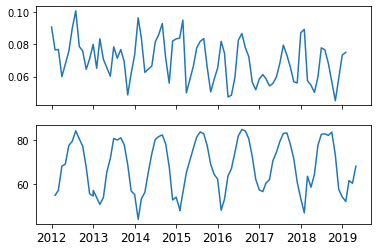

In [180]:
create_plot(he_mean, w)

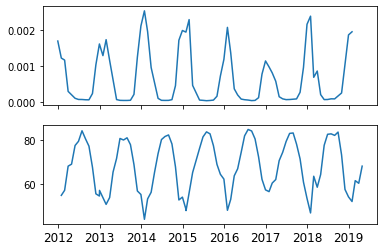

In [181]:
create_plot(hg_mean, w)

In [182]:
e_mean.to_csv('/home/mirabel/Documents/cds/means/elec_residential.csv', index=False)
g_mean.to_csv('/home/mirabel/Documents/cds/means/gas_residential.csv', index=False)
he_mean.to_csv('/home/mirabel/Documents/cds/means/elec_home.csv', index=False)
hg_mean.to_csv('/home/mirabel/Documents/cds/means/gas_home.csv', index=False)